# Waste Principal Component Analysis (PCA) and Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error)
from sklearn.preprocessing import PowerTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from IPython.display import display

# Import waste dataframe
waste=pd.read_csv('waste.csv')

In [3]:
waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                4809 non-null   object 
 1   account_id                  4809 non-null   int64  
 2   Year                        4809 non-null   int64  
 3   incorporated_country        4809 non-null   object 
 4   Primary activity            4809 non-null   object 
 5   Primary sector              4809 non-null   object 
 6   Market_Cap_USD              4092 non-null   float64
 7   Third_party_verification    4807 non-null   object 
 8   Revenue_USD                 4109 non-null   float64
 9   ebitda_USD                  4109 non-null   float64
 10  grossProfit_USD             4109 non-null   float64
 11  netIncome_USD               4109 non-null   float64
 12  cashAndCashEquivalents_USD  4109 non-null   float64
 13  shortTermInvestments_USD    4109 

In [2]:
waste.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9.548124e+09,Third-party verification or assurance process ...,1.728470e+09,1.565910e+09,...,8.544560e+09,1.107567e+10,1.031240e+09,8.544560e+09,7.302500e+08,1.004443e+10,Waste generated in operations,57.21,338.950000,4072324
1,abrdn,17604,2018,United Kingdom,Insurance,Financial services,1.019344e+10,Third-party verification or assurance process ...,2.912110e+09,1.482090e+09,...,6.626860e+09,1.589659e+10,6.322060e+09,6.626860e+09,1.647190e+09,9.574530e+09,Waste generated in operations,14.13,7197.250000,4072324
2,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,9.900000e+07,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,Waste generated in operations,104000.00,380471.810000,4072324
3,AstraZeneca,1104,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.441091e+10,Third-party verification or assurance process ...,2.209000e+10,7.165000e+09,...,1.130000e+08,6.065100e+10,4.660700e+10,9.220000e+08,1.911300e+10,1.404400e+10,Waste generated in operations,25361.00,707252.916667,4072324
4,Aviva plc,1268,2018,United Kingdom,Insurance,Financial services,1.880010e+10,Third-party verification or assurance process ...,2.828417e+10,2.565400e+08,...,7.073011e+10,5.454917e+11,1.164463e+10,8.914511e+10,1.360678e+10,2.343785e+10,Waste generated in operations,81.00,61086.500000,4072324


In [4]:
# Rename features
waste = waste.rename(columns={'incorporated_country': 'Countries',
                                          'Primary activity': 'Primary_activity',
                                          'Primary sector': 'Primary_sector'})

# Drop unneeded columns
waste = waste.drop(
    ['Third_party_verification', 'Scope_3_emissions_type'], axis=1, errors='ignore')

waste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                4809 non-null   object 
 1   account_id                  4809 non-null   int64  
 2   Year                        4809 non-null   int64  
 3   Countries                   4809 non-null   object 
 4   Primary_activity            4809 non-null   object 
 5   Primary_sector              4809 non-null   object 
 6   Market_Cap_USD              4092 non-null   float64
 7   Revenue_USD                 4109 non-null   float64
 8   ebitda_USD                  4109 non-null   float64
 9   grossProfit_USD             4109 non-null   float64
 10  netIncome_USD               4109 non-null   float64
 11  cashAndCashEquivalents_USD  4109 non-null   float64
 12  shortTermInvestments_USD    4109 non-null   float64
 13  longTermInvestments_USD     4109 

In [5]:
# Looking at missing data
print(waste.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                14.9
cashAndCashEquivalents_USD    14.6
totalLiabilities_USD          14.6
totalEquity_USD               14.6
totalDebt_USD                 14.6
Revenue_USD                   14.6
ebitda_USD                    14.6
grossProfit_USD               14.6
netIncome_USD                 14.6
totalInvestments_USD          14.6
shortTermInvestments_USD      14.6
longTermInvestments_USD       14.6
totalAssets_USD               14.6
scope_1_2_emissions_amount     0.3
Scope_3_emissions_amount       0.0
account_name                   0.0
account_id                     0.0
Primary_sector                 0.0
Primary_activity               0.0
Countries                      0.0
Year                           0.0
Year_sq                        0.0
dtype: float64


### Principal Component Analysis (PCA) — Waste Dataset

- Selects relevant numeric features, excluding identifiers and categorical columns.
- Applies a signed log transformation to reduce skewness and handle zeros/negatives.
- Drops rows with missing values for PCA input.
- Standardizes features before fitting PCA.
- Computes principal components and appends scores back to the original dataset for valid rows.
- Visualizes explained variance by component (scree plot and cumulative plot).
- Prints cumulative variance explained by each principal component for interpretation.

_Result:_  
The `waste_with_pcs` DataFrame contains all original columns plus principal component scores for rows with complete, transformed input data, enabling robust downstream analysis.

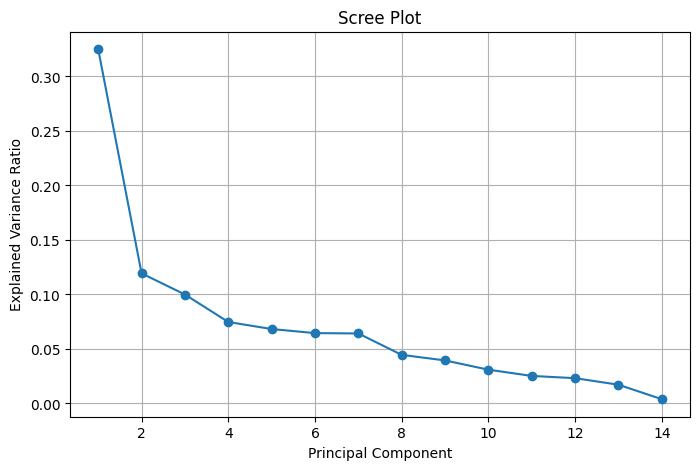

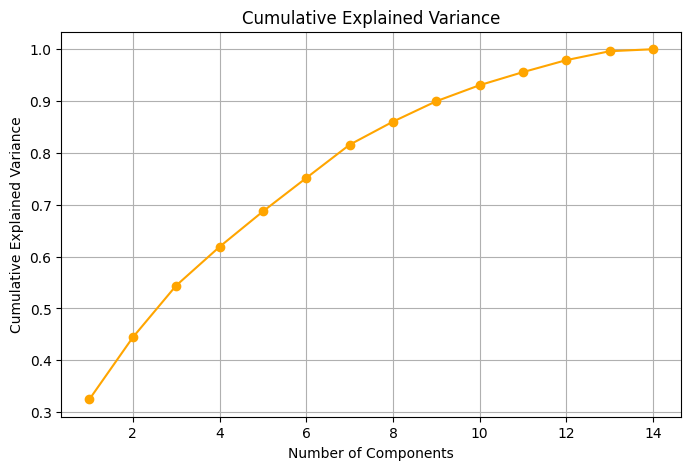

Cumulative variance explained by each additional principal component:
  PC1: 0.3250
  PC2: 0.4443
  PC3: 0.5442
  PC4: 0.6189
  PC5: 0.6871
  PC6: 0.7516
  PC7: 0.8158
  PC8: 0.8603
  PC9: 0.8997
  PC10: 0.9307
  PC11: 0.9559
  PC12: 0.9790
  PC13: 0.9962
  PC14: 1.0000


In [6]:
# --- STEP 1: Select appropriate columns for PCA ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in waste.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(waste[col])
    and col != "Scope_3_emissions_amount"
]
X = waste[numeric_cols].copy()

# --- STEP 2: Apply sign-log transformation ---
def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)

# --- STEP 3: Drop rows with missing values (keep track of indices) ---
X_dropped = X_transformed.dropna()
pca_indices = X_dropped.index

# --- STEP 4: Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

# --- STEP 5: Fit PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- STEP 6: Create a DataFrame for PCs, index matches original ---
num_pcs = X_pca.shape[1]
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
pcs_df = pd.DataFrame(X_pca, columns=pc_columns, index=pca_indices)

# --- STEP 7: Append PCs back to the original DataFrame (only for valid rows) ---
waste_with_pcs = waste.copy()
for col in pc_columns:
    waste_with_pcs[col] = np.nan  # initialize with NaN

waste_with_pcs.loc[pcs_df.index, pc_columns] = pcs_df

# --- Plots ---
explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_var_ratio) + 1),
    np.cumsum(explained_var_ratio),
    marker='o',
    color='orange'
)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# --- Print cumulative variance explained for each PC ---
cumulative_var = np.cumsum(explained_var_ratio)
print("Cumulative variance explained by each additional principal component:")
for i, var in enumerate(cumulative_var, start=1):
    print(f"  PC{i}: {var:.4f}")

Ten pc's explains >90% of the variance in the data, while 4 pc's is at the bottom of the "elbow" with much less significant return for each increase in number of pc's.  Seven pc's explains >80% of variance and reduces the potential for multicollinearity issues with a decreased number of pc's.<br>
I'll investigate 10 pc's, 7 pc's and 4 pc's performance on HLM models.

### PCA Feature Engineering and Data Splitting — Waste Dataset

- Applies signed log transformation to numeric features before standardization and PCA.
- Computes principal components for 10, 7, and 4 dimensions, appending PC scores to the original dataset.
- Transforms the target variable using signed log.
- Splits data into train (2018–2022) and test (2023) sets, restricting test to companies present in train.
- Both train and test datasets contain all original columns plus PC features and transformed target, ready for downstream modeling.

_Result:_  
`train_df` and `test_df` are fully featured for hierarchical modeling, clustering, and further analysis.

In [7]:
# --- Prepare Data ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in waste.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(waste[col])
    and col != "Scope_3_emissions_amount"
]
X = waste[numeric_cols].copy()

def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
# Apply sign-log transform to all numeric predictors
X_transformed = X.apply(sign_log_transform)

# Drop any rows with missing values for PCA input
pca_data = X_transformed.dropna().copy()
pca_data["account_id"] = waste.loc[pca_data.index, "account_id"]
pca_data["Year"] = waste.loc[pca_data.index, "Year"]

# Prepare PCA input (excluding ID and Year)
X_pca_input = pca_data.drop(columns=["account_id", "Year"])

# Standardize predictors AFTER sign-log transform
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

# --- PCA for 10 components ---
pca10 = PCA(n_components=10)
pcs10 = pca10.fit_transform(X_scaled)
pcs10_df = pd.DataFrame(pcs10, columns=[f"PC10_{i+1}" for i in range(10)], index=pca_data.index)

# --- PCA for 7 components ---
pca7 = PCA(n_components=7)
pcs7 = pca7.fit_transform(X_scaled)
pcs7_df = pd.DataFrame(pcs7, columns=[f"PC7_{i+1}" for i in range(7)], index=pca_data.index)

# --- PCA for 4 components ---
pca4 = PCA(n_components=4)
pcs4 = pca4.fit_transform(X_scaled)
pcs4_df = pd.DataFrame(pcs4, columns=[f"PC4_{i+1}" for i in range(4)], index=pca_data.index)

# --- Merge all PC features to original DataFrame ---
waste_pca = waste.copy()
waste_pca = waste_pca.join(pcs10_df)
waste_pca = waste_pca.join(pcs7_df)
waste_pca = waste_pca.join(pcs4_df)

# --- Add transformed target and optionally other features ---
waste_pca['slog_Scope_3_emissions_amount'] = sign_log_transform(waste_pca['Scope_3_emissions_amount'])

# Optional: Rename columns for consistency
waste_pca = waste_pca.rename(columns={'incorporated_country': 'Countries',
                                      'Primary activity': 'Primary_activity',
                                      'Primary sector': 'Primary_sector'})

# --- Split train/test by company and year ---
train_df = waste_pca[waste_pca['Year'].between(2018, 2022)].copy()
test_df  = waste_pca[waste_pca['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Now train_df and test_df contain all original columns plus PC10, PC7, PC4, and transformed target.

Train shape: (3885, 44)
Test shape: (876, 44)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3885 entries, 0 to 3884
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   3885 non-null   object 
 1   account_id                     3885 non-null   int64  
 2   Year                           3885 non-null   int64  
 3   Countries                      3885 non-null   object 
 4   Primary_activity               3885 non-null   object 
 5   Primary_sector                 3885 non-null   object 
 6   Market_Cap_USD                 3295 non-null   float64
 7   Revenue_USD                    3346 non-null   float64
 8   ebitda_USD                     3346 non-null   float64
 9   grossProfit_USD                3346 non-null   float64
 10  netIncome_USD                  3346 non-null   float64
 11  cashAndCashEquivalents_USD     3346 non-null   float64
 12  shortTermInvestments_USD       3346 non-null   float6

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 3885 to 4808
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   876 non-null    object 
 1   account_id                     876 non-null    int64  
 2   Year                           876 non-null    int64  
 3   Countries                      876 non-null    object 
 4   Primary_activity               876 non-null    object 
 5   Primary_sector                 876 non-null    object 
 6   Market_Cap_USD                 759 non-null    float64
 7   Revenue_USD                    727 non-null    float64
 8   ebitda_USD                     727 non-null    float64
 9   grossProfit_USD                727 non-null    float64
 10  netIncome_USD                  727 non-null    float64
 11  cashAndCashEquivalents_USD     727 non-null    float64
 12  shortTermInvestments_USD       727 non-null    floa

### Hierarchical Linear Mixed Model (HLM) Using 10 Principal Components — Waste Dataset

- Uses train and test splits containing all original columns and appended PC10 features.
- Filters for complete cases of PC10, transformed target, and contextual variables.
- Ensures categorical levels in test are present in train for fair evaluation.
- Fits a mixed-effects model with PC10 features, country, activity, and year as fixed effects, grouped by company.
- Reports regression metrics, feature importances, and visualizations for both log-transformed and original emissions.

_Result:_  
Enables robust mixed-effects modeling of Scope 3 emissions for waste, leveraging multivariate principal components and company context in train/test splits preserved for downstream analysis.

                                       Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              slog_Scope_3_emissions_amount
No. Observations:                3282                 Method:                          ML                           
No. Groups:                      769                  Scale:                           0.7989                       
Min. group size:                 1                    Log-Likelihood:                  -5128.1781                   
Max. group size:                 5                    Converged:                       Yes                          
Mean group size:                 4.3                                                                                
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [

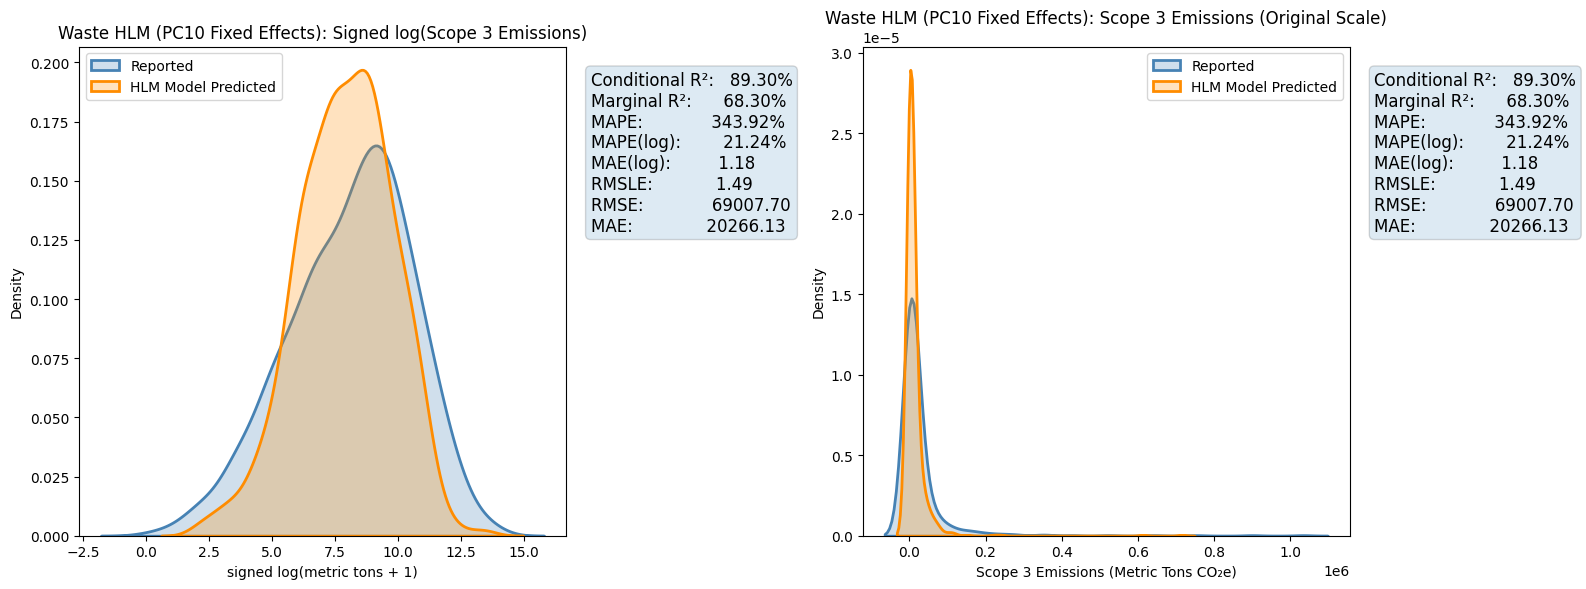

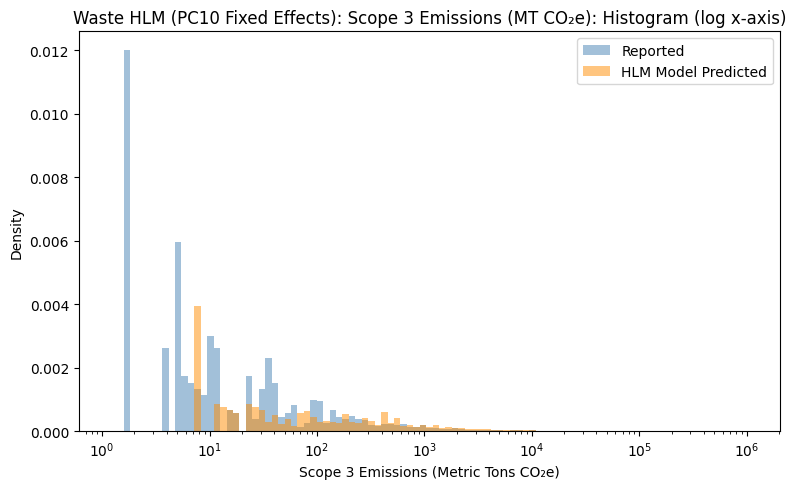

In [10]:
# --- Waste HLM with PC10 features, using previously created train/test splits ---

# Use train_df and test_df from previous PCA/splitting code (retains all columns)
feature_cols_PC10 = [f'PC10_{i+1}' for i in range(10)]
target_col_PC10 = 'slog_Scope_3_emissions_amount'
cat_cols_PC10 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC10 = feature_cols_PC10 + [target_col_PC10] + cat_cols_PC10

# Filter for required columns only (retain all columns for future use)
train_df_PC10 = train_df.dropna(subset=all_model_vars_PC10).copy()
test_df_PC10 = test_df.dropna(subset=all_model_vars_PC10).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC10[cat_col].unique())
    n_before = len(test_df_PC10)
    test_df_PC10 = test_df_PC10[test_df_PC10[cat_col].isin(train_cats)]
    n_after = len(test_df_PC10)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC10.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula (PC10 features as predictors) ---
    fixed_effects = (
        ' + '.join(feature_cols_PC10) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC10} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC10, groups=train_df_PC10['account_id'])
        mdf_PC10 = md.fit(reml=False)
    print(mdf_PC10.summary())

    # --- Calculate conditional and marginal R² ---
    var_fixed = np.var(mdf_PC10.fittedvalues)
    var_resid = mdf_PC10.scale
    var_random = mdf_PC10.cov_re.iloc[0, 0] if mdf_PC10.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_PC10['predicted_log'] = mdf_PC10.predict(test_df_PC10)
    test_df_PC10['predicted'] = np.sign(test_df_PC10['predicted_log']) * (np.expm1(np.abs(test_df_PC10['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_PC10[target_col_PC10]
    y_pred_log = test_df_PC10['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC10['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nWaste HLM with PC10 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC10.params,
        'pvalue': mdf_PC10.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Waste HLM (PC10 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Waste HLM (PC10 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    valid_hist_mask = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > -1) & (y_pred > -1)
    y_true_hist = y_true[valid_hist_mask]
    y_pred_hist = y_pred[valid_hist_mask]
    if len(y_true_hist) > 0 and len(y_pred_hist) > 0:
        min_val = min(y_true_hist.min(), y_pred_hist.min())
        max_val = max(y_true_hist.max(), y_pred_hist.max())
        if (min_val + 1) > 0 and (max_val + 1) > 0:
            log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
            plt.figure(figsize=(8, 5))
            sns.histplot(y_true_hist, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
            sns.histplot(y_pred_hist, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
            plt.xscale("log")
            plt.title("Waste HLM (PC10 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
            plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("Error: min_val or max_val invalid for log scaling.")
    else:
        print("Error: No valid y_true/y_pred values for histogram.")

    # --- Return metrics for summary table ---
    PC10_model_metrics = {
        "Model": "HLM PC10",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC10),
        "# Obs (test)": len(test_df_PC10),
        "# Obs (train/test)": f"{len(train_df_PC10)}/{len(test_df_PC10)}"
    }

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3885 entries, 0 to 3884
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   3885 non-null   object 
 1   account_id                     3885 non-null   int64  
 2   Year                           3885 non-null   int64  
 3   Countries                      3885 non-null   object 
 4   Primary_activity               3885 non-null   object 
 5   Primary_sector                 3885 non-null   object 
 6   Market_Cap_USD                 3295 non-null   float64
 7   Revenue_USD                    3346 non-null   float64
 8   ebitda_USD                     3346 non-null   float64
 9   grossProfit_USD                3346 non-null   float64
 10  netIncome_USD                  3346 non-null   float64
 11  cashAndCashEquivalents_USD     3346 non-null   float64
 12  shortTermInvestments_USD       3346 non-null   float6

### Hierarchical Linear Mixed Model (HLM) Using 7 Principal Components — Waste Dataset

- Uses train and test splits containing all original columns and appended PC7 features.
- Filters for complete cases of PC7, transformed target, and contextual variables.
- Ensures categorical levels in test are present in train for fair evaluation.
- Fits a mixed-effects model with PC7 features, country, activity, and year as fixed effects, grouped by company.
- Reports regression metrics, feature importances, and visualizations for both log-transformed and original emissions.

_Result:_  
Enables robust mixed-effects modeling of Scope 3 emissions for waste, leveraging 7 principal components and company context in train/test splits preserved for downstream analysis.

                                       Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              slog_Scope_3_emissions_amount
No. Observations:                3282                 Method:                          ML                           
No. Groups:                      769                  Scale:                           0.8013                       
Min. group size:                 1                    Log-Likelihood:                  -5144.6399                   
Max. group size:                 5                    Converged:                       Yes                          
Mean group size:                 4.3                                                                                
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [

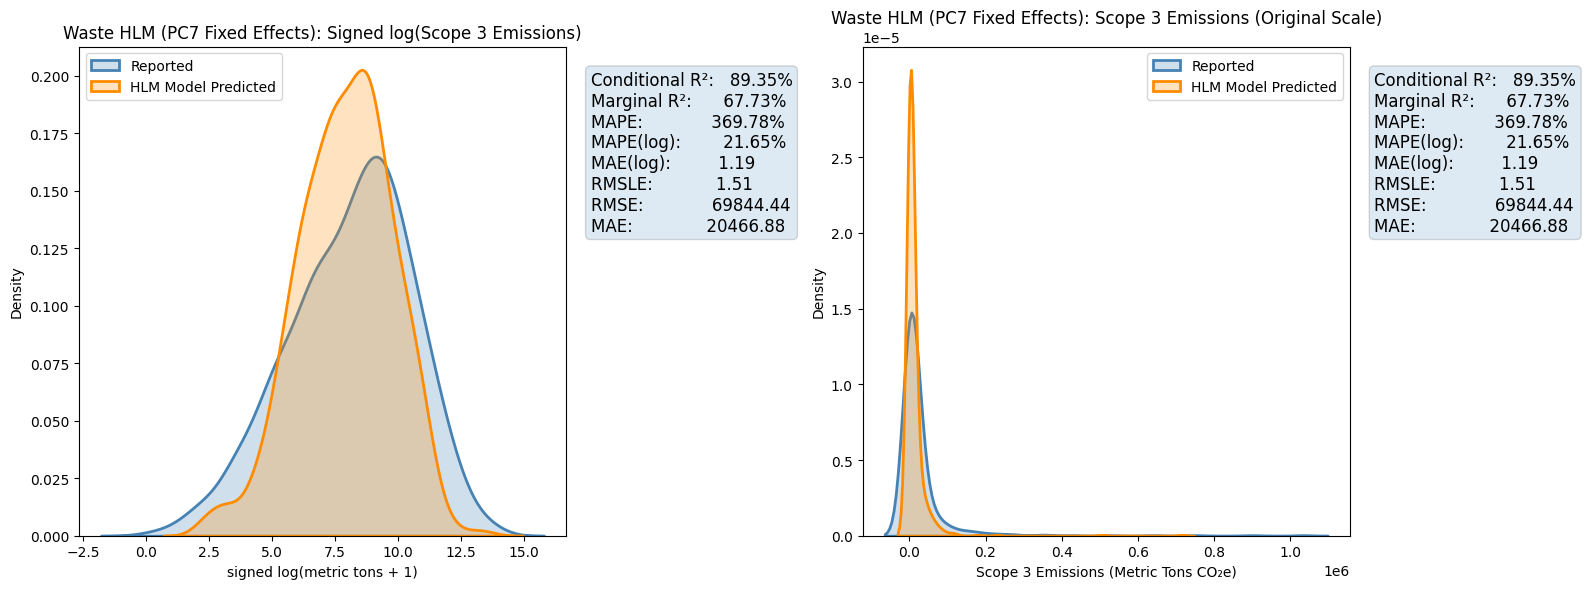

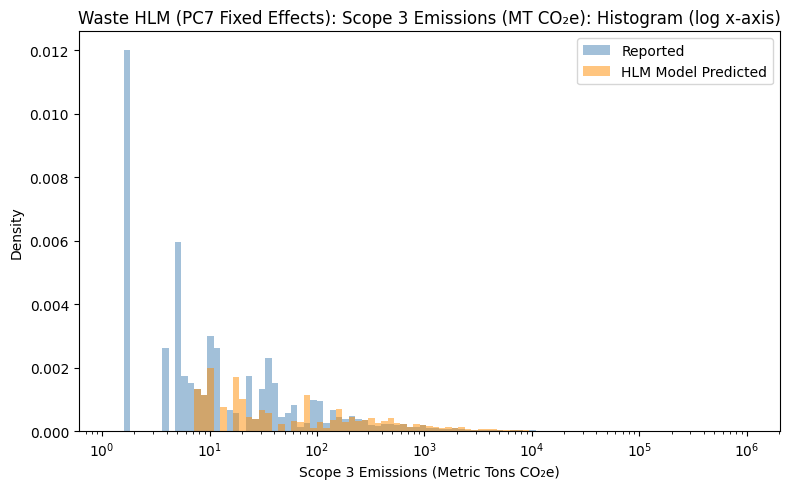

In [12]:
# --- Waste HLM with PC7 features, using previously created train/test splits ---

# Use train_df and test_df from previous PCA/splitting code (retains all columns)
feature_cols_PC7 = [f'PC7_{i+1}' for i in range(7)]
target_col_PC7 = 'slog_Scope_3_emissions_amount'
cat_cols_PC7 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC7 = feature_cols_PC7 + [target_col_PC7] + cat_cols_PC7

# Filter for required columns only (retain all columns for future use)
train_df_PC7 = train_df.dropna(subset=all_model_vars_PC7).copy()
test_df_PC7 = test_df.dropna(subset=all_model_vars_PC7).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC7[cat_col].unique())
    n_before = len(test_df_PC7)
    test_df_PC7 = test_df_PC7[test_df_PC7[cat_col].isin(train_cats)]
    n_after = len(test_df_PC7)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC7.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula (PC7 features as predictors) ---
    fixed_effects = (
        ' + '.join(feature_cols_PC7) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC7} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC7, groups=train_df_PC7['account_id'])
        mdf_PC7 = md.fit(reml=False)
    print(mdf_PC7.summary())

    # --- Calculate conditional and marginal R² ---
    var_fixed = np.var(mdf_PC7.fittedvalues)
    var_resid = mdf_PC7.scale
    var_random = mdf_PC7.cov_re.iloc[0, 0] if mdf_PC7.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_PC7['predicted_log'] = mdf_PC7.predict(test_df_PC7)
    test_df_PC7['predicted'] = np.sign(test_df_PC7['predicted_log']) * (np.expm1(np.abs(test_df_PC7['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_PC7[target_col_PC7]
    y_pred_log = test_df_PC7['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC7['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nWaste HLM with PC7 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC7.params,
        'pvalue': mdf_PC7.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Waste HLM (PC7 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Waste HLM (PC7 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    valid_hist_mask = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > -1) & (y_pred > -1)
    y_true_hist = y_true[valid_hist_mask]
    y_pred_hist = y_pred[valid_hist_mask]
    if len(y_true_hist) > 0 and len(y_pred_hist) > 0:
        min_val = min(y_true_hist.min(), y_pred_hist.min())
        max_val = max(y_true_hist.max(), y_pred_hist.max())
        if (min_val + 1) > 0 and (max_val + 1) > 0:
            log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
            plt.figure(figsize=(8, 5))
            sns.histplot(y_true_hist, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
            sns.histplot(y_pred_hist, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
            plt.xscale("log")
            plt.title("Waste HLM (PC7 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
            plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("Error: min_val or max_val invalid for log scaling.")
    else:
        print("Error: No valid y_true/y_pred values for histogram.")

    # --- Return metrics for summary table ---
    PC7_model_metrics = {
        "Model": "HLM PC7",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC7),
        "# Obs (test)": len(test_df_PC7),
        "# Obs (train/test)": f"{len(train_df_PC7)}/{len(test_df_PC7)}"
    }

### Hierarchical Linear Mixed Model (HLM) Using 4 Principal Components — Waste Dataset

- Uses train and test splits containing all original columns and appended PC4 features.
- Filters for complete cases of PC4, transformed target, and contextual variables.
- Ensures categorical levels in test are present in train for fair evaluation.
- Fits a mixed-effects model with PC4 features, country, activity, and year as fixed effects, grouped by company.
- Reports regression metrics, feature importances, and visualizations for both log-transformed and original emissions.

_Result:_  
Enables robust mixed-effects modeling of Scope 3 emissions for waste, leveraging 4 principal components and company context in train/test splits preserved for downstream analysis.

                                       Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              slog_Scope_3_emissions_amount
No. Observations:                3282                 Method:                          ML                           
No. Groups:                      769                  Scale:                           0.7976                       
Min. group size:                 1                    Log-Likelihood:                  -5176.9183                   
Max. group size:                 5                    Converged:                       Yes                          
Mean group size:                 4.3                                                                                
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [

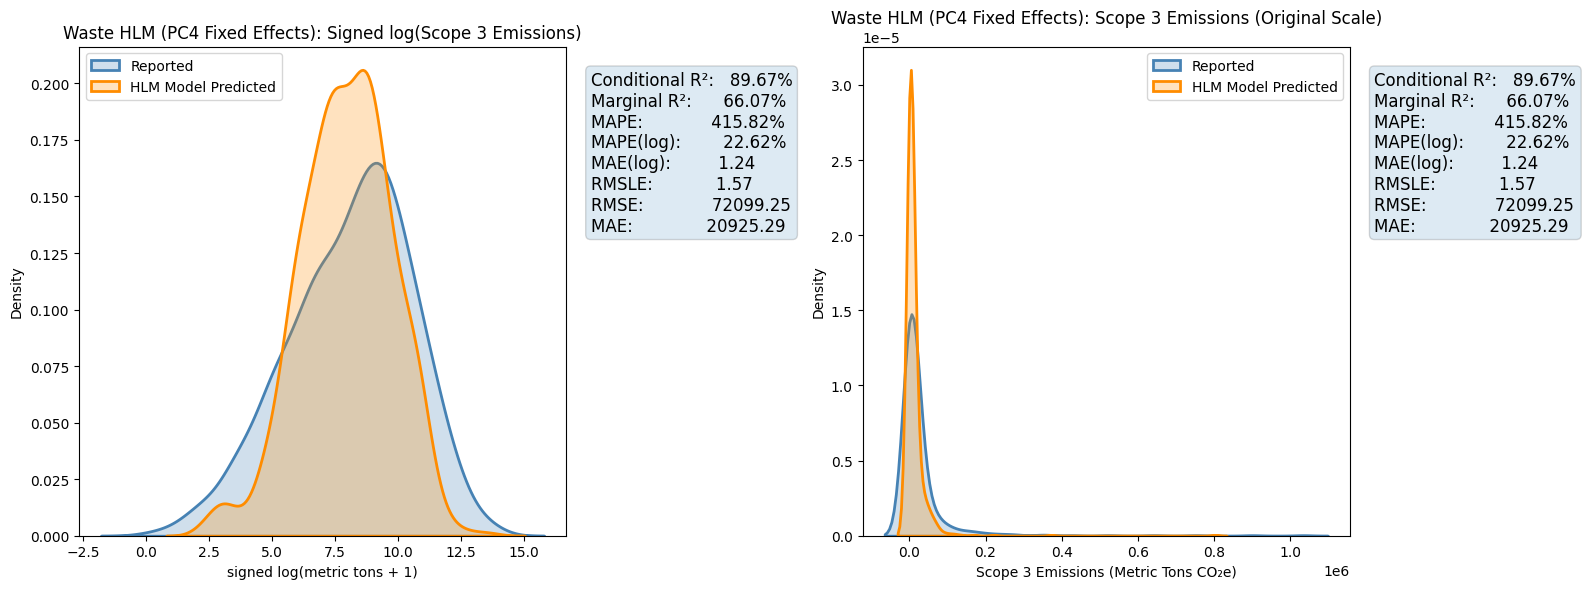

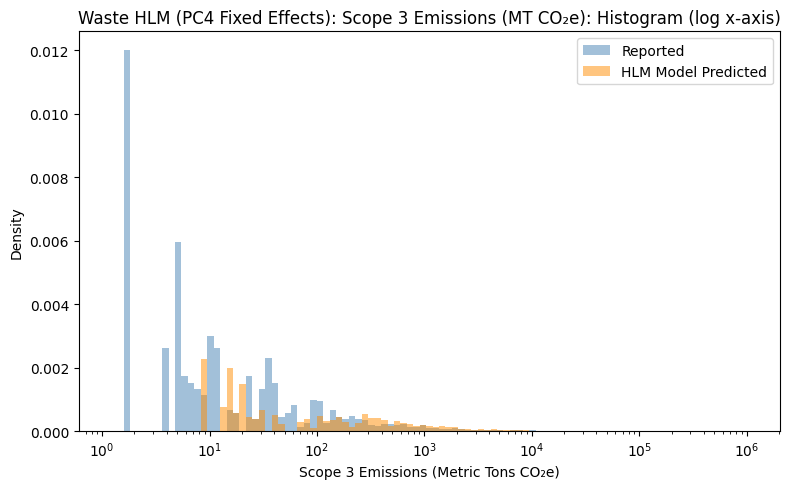

In [13]:
# --- Waste HLM with PC4 features, using previously created train/test splits ---

# Use train_df and test_df from previous PCA/splitting code (retains all columns)
feature_cols_PC4 = [f'PC4_{i+1}' for i in range(4)]
target_col_PC4 = 'slog_Scope_3_emissions_amount'
cat_cols_PC4 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC4 = feature_cols_PC4 + [target_col_PC4] + cat_cols_PC4

# Filter for required columns only (retain all columns for future use)
train_df_PC4 = train_df.dropna(subset=all_model_vars_PC4).copy()
test_df_PC4 = test_df.dropna(subset=all_model_vars_PC4).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC4[cat_col].unique())
    n_before = len(test_df_PC4)
    test_df_PC4 = test_df_PC4[test_df_PC4[cat_col].isin(train_cats)]
    n_after = len(test_df_PC4)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC4.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula (PC4 features as predictors) ---
    fixed_effects = (
        ' + '.join(feature_cols_PC4) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC4} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC4, groups=train_df_PC4['account_id'])
        mdf_PC4 = md.fit(reml=False)
    print(mdf_PC4.summary())

    # --- Calculate conditional and marginal R² ---
    var_fixed = np.var(mdf_PC4.fittedvalues)
    var_resid = mdf_PC4.scale
    var_random = mdf_PC4.cov_re.iloc[0, 0] if mdf_PC4.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_PC4['predicted_log'] = mdf_PC4.predict(test_df_PC4)
    test_df_PC4['predicted'] = np.sign(test_df_PC4['predicted_log']) * (np.expm1(np.abs(test_df_PC4['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_PC4[target_col_PC4]
    y_pred_log = test_df_PC4['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC4['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nWaste HLM with PC4 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC4.params,
        'pvalue': mdf_PC4.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Waste HLM (PC4 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Waste HLM (PC4 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    valid_hist_mask = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > -1) & (y_pred > -1)
    y_true_hist = y_true[valid_hist_mask]
    y_pred_hist = y_pred[valid_hist_mask]
    if len(y_true_hist) > 0 and len(y_pred_hist) > 0:
        min_val = min(y_true_hist.min(), y_pred_hist.min())
        max_val = max(y_true_hist.max(), y_pred_hist.max())
        if (min_val + 1) > 0 and (max_val + 1) > 0:
            log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
            plt.figure(figsize=(8, 5))
            sns.histplot(y_true_hist, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
            sns.histplot(y_pred_hist, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
            plt.xscale("log")
            plt.title("Waste HLM (PC4 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
            plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("Error: min_val or max_val invalid for log scaling.")
    else:
        print("Error: No valid y_true/y_pred values for histogram.")

    # --- Return metrics for summary table ---
    PC4_model_metrics = {
        "Model": "HLM PC4",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC4),
        "# Obs (test)": len(test_df_PC4),
        "# Obs (train/test)": f"{len(train_df_PC4)}/{len(test_df_PC4)}"
    }

Now I'll look into hierarchical clustering to determine if that may add value to increasing prediction accuracy.

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3885 entries, 0 to 3884
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   3885 non-null   object 
 1   account_id                     3885 non-null   int64  
 2   Year                           3885 non-null   int64  
 3   Countries                      3885 non-null   object 
 4   Primary_activity               3885 non-null   object 
 5   Primary_sector                 3885 non-null   object 
 6   Market_Cap_USD                 3295 non-null   float64
 7   Revenue_USD                    3346 non-null   float64
 8   ebitda_USD                     3346 non-null   float64
 9   grossProfit_USD                3346 non-null   float64
 10  netIncome_USD                  3346 non-null   float64
 11  cashAndCashEquivalents_USD     3346 non-null   float64
 12  shortTermInvestments_USD       3346 non-null   float6

### Hierarchical Clustering on PC4 Features and Updating Train/Test Splits — Waste Dataset

- Performs hierarchical clustering on all valid rows in the main dataset using the first 4 PCA components (PC4).
- Finds the optimal number of clusters via silhouette scores.
- Appends the resulting cluster labels as a new `Cluster` column to the main dataset (`waste_pca_clusters`).
- Updates train and test splits (`train_df`, `test_df`) to include the `Cluster` feature for each row, aligning with the clustering performed on the full dataset.
- The clustering is always performed on the full main dataset, and not just the train or test splits.

**Result:**  
Both train and test DataFrames for downstream modeling now contain the assigned cluster label, enabling stratified modeling and cluster-aware hierarchical analyses.

Optimal number of clusters (highest silhouette score): 3


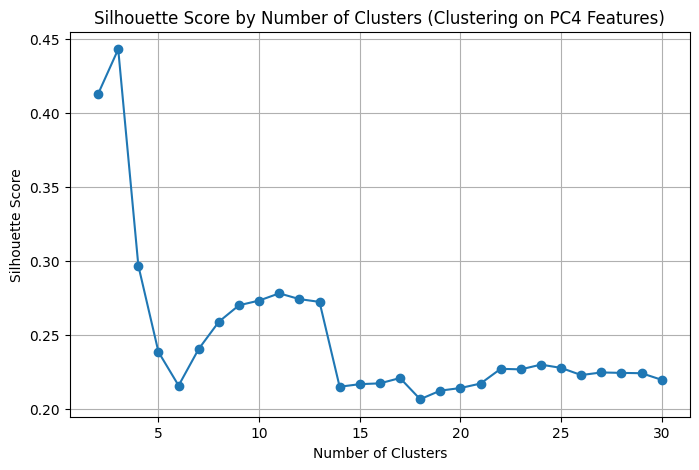

Number of observations in each cluster:
3    3519
1     382
2     133
Name: count, dtype: int64


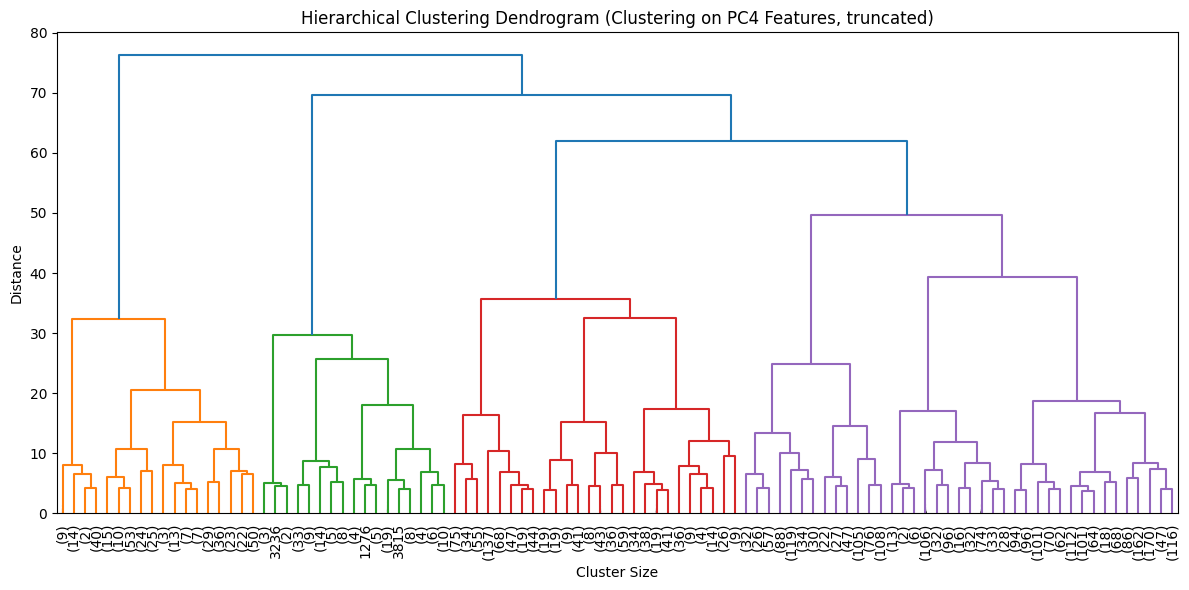

Train shape (with Cluster): (3885, 45)
Test shape (with Cluster): (876, 45)


In [15]:
# --- STEP 1: Select PC4 PCA components for clustering (on all data) ---
pc4_cols = [f'PC4_{i+1}' for i in range(4)]
X_pc4 = waste_pca[pc4_cols].dropna()
clust_indices = X_pc4.index

# --- STEP 2: Standardize the PC4 data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pc4)

# --- STEP 3: Hierarchical clustering (Ward linkage) ---
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score

Z = linkage(X_scaled, method='ward')

# --- STEP 4: Find optimal number of clusters using silhouette score ---
range_n_clusters = range(2, 31)  # 2 to 30 clusters
sil_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"Optimal number of clusters (highest silhouette score): {optimal_n_clusters}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (Clustering on PC4 Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# --- STEP 5: Assign optimal cluster labels ---
labels_optimal = fcluster(Z, optimal_n_clusters, criterion='maxclust')

# --- STEP 6: Append cluster labels back to main DataFrame (only for valid rows) ---
waste_pca_clusters = waste_pca.copy()
waste_pca_clusters['Cluster'] = np.nan  # initialize with NaN
waste_pca_clusters.loc[clust_indices, 'Cluster'] = labels_optimal

# --- Print cluster counts ---
print("Number of observations in each cluster:")
print(pd.Series(labels_optimal).value_counts())

# --- Optionally plot dendrogram (subset for readability) ---
plt.figure(figsize=(12, 6))
sample_size = min(100, len(X_scaled))  # Plot up to 100 samples for clarity
dendrogram(Z, truncate_mode='lastp', p=sample_size, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Clustering on PC4 Features, truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# --- STEP 7: Update train/test splits with Cluster labels ---
# (Assumes train_df and test_df already exist and are indexed on waste_pca_clusters)
train_df = train_df.copy()
test_df = test_df.copy()
train_df['Cluster'] = waste_pca_clusters.loc[train_df.index, 'Cluster']
test_df['Cluster'] = waste_pca_clusters.loc[test_df.index, 'Cluster']

print("Train shape (with Cluster):", train_df.shape)
print("Test shape (with Cluster):", test_df.shape)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3885 entries, 0 to 3884
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   3885 non-null   object 
 1   account_id                     3885 non-null   int64  
 2   Year                           3885 non-null   int64  
 3   Countries                      3885 non-null   object 
 4   Primary_activity               3885 non-null   object 
 5   Primary_sector                 3885 non-null   object 
 6   Market_Cap_USD                 3295 non-null   float64
 7   Revenue_USD                    3346 non-null   float64
 8   ebitda_USD                     3346 non-null   float64
 9   grossProfit_USD                3346 non-null   float64
 10  netIncome_USD                  3346 non-null   float64
 11  cashAndCashEquivalents_USD     3346 non-null   float64
 12  shortTermInvestments_USD       3346 non-null   float6

### Hierarchical Linear Mixed Model (HLM) Using PC4 Principal Components and Cluster Labels — Waste Dataset

- Uses train and test splits that have been updated to include the `Cluster` feature from global clustering on PC4 components.
- Filters for complete cases of PC4, `Cluster`, transformed target, and contextual variables.
- Ensures categorical levels in test are present in train for fair evaluation (including clusters).
- Fits a mixed-effects model with PC4 features and cluster membership, country, activity, and year as fixed effects, grouped by company.
- Reports regression metrics, feature importances, and visualizations for both log-transformed and original emissions.

_Result:_  
Enables robust mixed-effects modeling of Scope 3 emissions for waste, leveraging principal component structure and cluster context in train/test splits preserved for downstream analysis.

                                       Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              slog_Scope_3_emissions_amount
No. Observations:                3282                 Method:                          ML                           
No. Groups:                      769                  Scale:                           0.7967                       
Min. group size:                 1                    Log-Likelihood:                  -5176.0664                   
Max. group size:                 5                    Converged:                       Yes                          
Mean group size:                 4.3                                                                                
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [

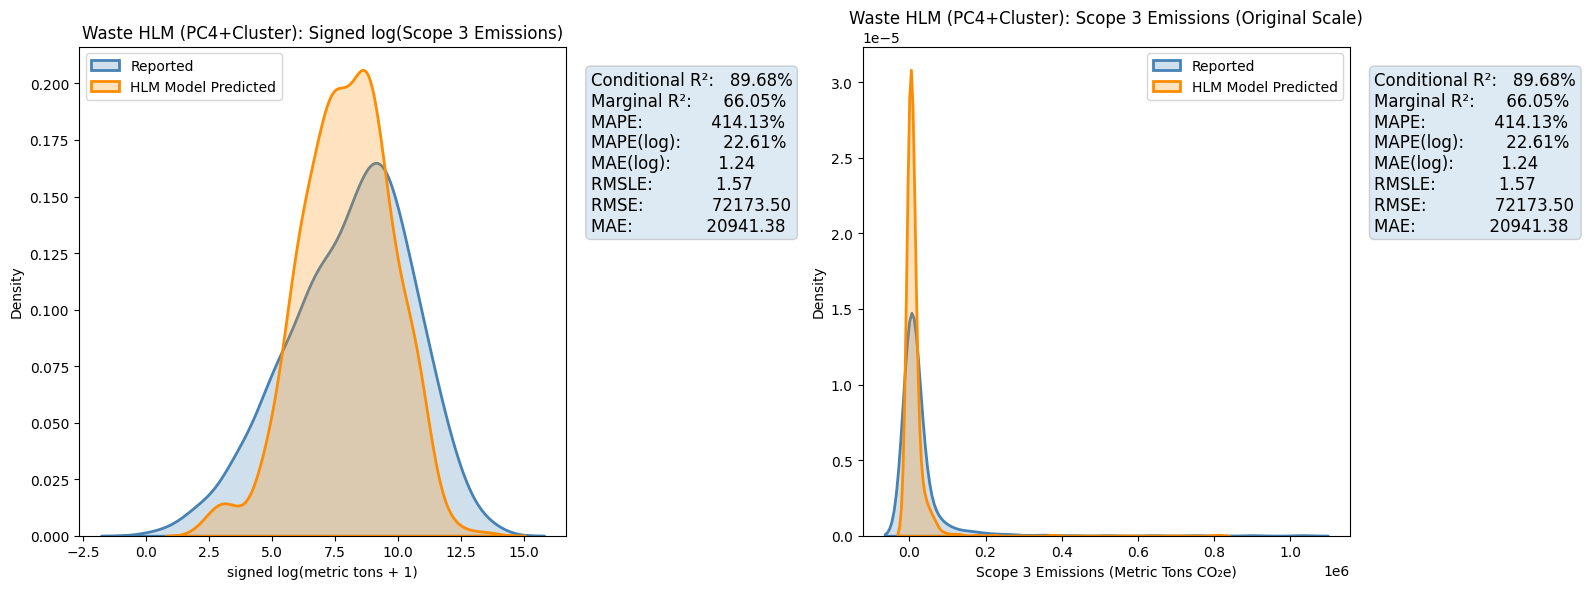

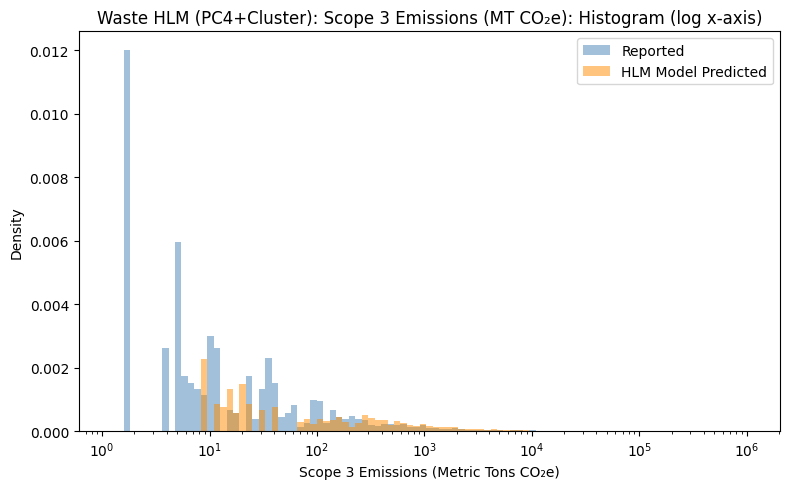

In [17]:
# --- PC4 + Cluster HLM ---

# Use train_df and test_df that already include the Cluster feature from previous clustering code
feature_cols_pc4_cluster = [f'PC4_{i+1}' for i in range(4)] + ['Cluster']  # Use capital 'C' for cluster column
target_col = 'slog_Scope_3_emissions_amount'
cat_cols = ['Countries', 'Year', 'account_id', 'Primary_activity']

# All model variables for current run
all_model_vars = feature_cols_pc4_cluster + [target_col] + cat_cols

# --- Prepare Data ---
train_df_pc4c = train_df.dropna(subset=all_model_vars).copy()
test_df_pc4c  = test_df.dropna(subset=all_model_vars).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity', 'Cluster']:
    train_cats = set(train_df_pc4c[cat_col].unique())
    n_before = len(test_df_pc4c)
    test_df_pc4c = test_df_pc4c[test_df_pc4c[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4c)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4c.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join([f'C({col})' if col == 'Cluster' else col for col in feature_cols_pc4_cluster]) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_pc4c, groups=train_df_pc4c['account_id'])
        mdf_pc4c = md.fit(reml=False)
    print(mdf_pc4c.summary())

    # --- Calculate conditional and marginal R² ---
    var_fixed = np.var(mdf_pc4c.fittedvalues)
    var_resid = mdf_pc4c.scale
    var_random = mdf_pc4c.cov_re.iloc[0, 0] if mdf_pc4c.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_pc4c['predicted_log'] = mdf_pc4c.predict(test_df_pc4c)
    test_df_pc4c['predicted'] = np.sign(test_df_pc4c['predicted_log']) * (np.expm1(np.abs(test_df_pc4c['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_pc4c[target_col]
    y_pred_log = test_df_pc4c['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4c['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nWaste HLM with PC4+Cluster Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4c.params,
        'pvalue': mdf_pc4c.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Waste HLM (PC4+Cluster): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Waste HLM (PC4+Cluster): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    valid_hist_mask = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > -1) & (y_pred > -1)
    y_true_hist = y_true[valid_hist_mask]
    y_pred_hist = y_pred[valid_hist_mask]
    if len(y_true_hist) > 0 and len(y_pred_hist) > 0:
        min_val = min(y_true_hist.min(), y_pred_hist.min())
        max_val = max(y_true_hist.max(), y_pred_hist.max())
        if (min_val + 1) > 0 and (max_val + 1) > 0:
            log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
            plt.figure(figsize=(8, 5))
            sns.histplot(y_true_hist, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
            sns.histplot(y_pred_hist, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
            plt.xscale("log")
            plt.title("Waste HLM (PC4+Cluster): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
            plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("Error: min_val or max_val invalid for log scaling.")
    else:
        print("Error: No valid y_true/y_pred values for histogram.")

    # --- Return metrics for summary table ---
    PC4_cluster_model_metrics = {
        "Model": "HLM PC4+Cluster",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4c),
        "# Obs (test)": len(test_df_pc4c),
        "# Obs (train/test)": f"{len(train_df_pc4c)}/{len(test_df_pc4c)}"
    }

### Model Metrics Summary: Waste HLM Models

In [22]:
# Collect metrics dicts from each model; change names as needed
metrics_dicts = [
    PC10_model_metrics,         # e.g., "HLM PC10"
    PC7_model_metrics,          # e.g., "HLM PC7"
    PC4_model_metrics,          # e.g., "HLM PC4"
    PC4_cluster_model_metrics   # e.g., "HLM PC4 + Cluster"
]

# Attach observation counts, convergence status, and explained variance to each dictionary
for metrics, train, test, fit_result, explained_var in zip(
        metrics_dicts,
        [train_df_PC10, train_df_PC7, train_df_PC4, train_df_pc4c],
        [test_df_PC10, test_df_PC7, test_df_PC4, test_df_pc4c],
        [mdf_PC10, mdf_PC7, mdf_PC4, mdf_pc4c],
        [
            sum(pca10.explained_variance_ratio_),
            sum(pca7.explained_variance_ratio_),
            sum(pca4.explained_variance_ratio_),
            sum(pca4.explained_variance_ratio_)
        ]):
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"
    metrics["Converged"] = "Yes" if getattr(fit_result, "converged", False) else "No"
    metrics["PC Explained Variance"] = explained_var

# Add a new row for your "Optimized" model
optimized_row = {
    "Model": "Optimized Waste HLM",
    "Conditional_R2": 0.8918,
    "Marginal_R2": 0.6863,
    "RMSE": 70358.03,
    "MAE": 20434.43,
    "MAE_log": 1.13,
    "RMSLE": 1.43,
    "MAPE": 333.04,
    "# Obs (train/test)": "3282/678",
    "PC Explained Variance": np.nan,
    "Converged": "Yes"
}
metrics_dicts.append(optimized_row)

metrics_df = pd.DataFrame(metrics_dicts)

# Order columns for summary (Converged LAST)
desired_order = [
    "Model", "PC Explained Variance", "Conditional_R2", "Marginal_R2", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)", "Converged"
]

# Add MAE_log if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

# Format for display
metrics_df_display = metrics_df.copy()
if "Conditional_R2" in metrics_df_display.columns:
    metrics_df_display["Conditional_R2"] = (metrics_df_display["Conditional_R2"].astype(float) * 100).map("{:.2f}%".format)
if "Marginal_R2" in metrics_df_display.columns:
    metrics_df_display["Marginal_R2"] = (metrics_df_display["Marginal_R2"].astype(float) * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "PC Explained Variance"]:
    if col in metrics_df_display.columns:
        if col == "PC Explained Variance":
            metrics_df_display[col] = metrics_df_display[col].apply(lambda v: "{:.2%}".format(v) if pd.notnull(v) else "")
        else:
            metrics_df_display[col] = metrics_df_display[col].astype(float).map("{:.2f}".format)

# Display in notebook or print
try:
    display(metrics_df_display)
except Exception:
    print(metrics_df_display.to_string(index=False))

,Model,PC Explained Variance,Conditional_R2,Marginal_R2,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test),Converged
0,HLM PC10,93.07%,89.30%,68.30%,69007.70,20266.13,1.18,1.49,343.92,3282/713,Yes
1,HLM PC7,81.58%,89.35%,67.73%,69844.44,20466.88,1.19,1.51,369.78,3282/713,Yes
2,HLM PC4,61.89%,89.67%,66.07%,72099.25,20925.29,1.24,1.57,415.82,3282/713,Yes
3,HLM PC4+Cluster,61.89%,89.68%,66.05%,72173.50,20941.38,1.24,1.57,414.13,3282/713,Yes
4,Optimized Waste HLM,,89.18%,68.63%,70358.03,20434.43,1.13,1.43,333.04,3282/678,Yes
